In [1]:
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt

import HTC
import time

In [2]:
# Load connectome and normalize it
W=np.loadtxt("../Data/connectivity_matrix/weights.txt")
W=W/W.sum(axis=1)[:,None]

# Create brain object and set its parameters
brain=HTC.Brain()
brain.connectome(W)
n_neurons=brain.n_neurons
brain.set_netowrk_parameters(r1=2/n_neurons, r2=(2/n_neurons)**0.2)#, tc=0.15)

# Generate initial configuration with 10% active neurons
#states_orig = HTC.generate_initial_conf(active_frac=0.1, n_neurons=brain.n_neurons, n_runs=50) # with random configurations

# Evolve over time the states (save every step in activity matrix)
n_timesteps=6000
n_runs=50

output=brain.simulation(active_frac=0.5,n_runs=n_runs,tmin=0.0, tmax=0.3, delta_tc=0.01, dt=0.1,
                        n_timesteps=n_timesteps, save_rtn=True)
#activity=np.zeros((n_runs,n_timesteps, brain.n_neurons)) #storing time, run and activity
#states=states_orig

# Dummy adjustment of system
#for t in range(100):
#    states, _ = HTC.update_states(states=states,r1=brain.r1,r2= brain.r2,tc= 0.15,W= W)
# Real simulation
#for t in range(n_timesteps):
#    states, activity[:,t] = HTC.update_states(states=states,r1=brain.r1,r2= brain.r2,tc= 0.15,W= W)

Connectome loaded but not yet normalized
r1 and r2 parameters now set successfully


In [3]:
tc = np.arange(0.0, 0.3, 0.01, dtype=np.float64)
tc[15]

0.15

In [4]:
output['activity_rtn'].shape

(30, 50, 6000, 66)

In [5]:
sample_rate=1/0.1
nyquist_freq=sample_rate/2
a1=6
a2=12
b=0.9
c=0.35
d1=a1*b
d2=a2*b

time=np.arange(n_timesteps)/sample_rate
tt=np.arange(250)/sample_rate

hrf=((tt/d1)**a1)*np.exp(-(tt-d1)/b)-c*((tt/d2)**a2)*np.exp(-(tt-d2)/b)

In [6]:
# FIR filter
ntaps=115
band=[0.01/nyquist_freq,0.1/nyquist_freq]
delay = 0.5 * (ntaps-1) / sample_rate

filt_fir = signal.firwin(ntaps, band,
                                 pass_zero=False, window='blackmanharris')

convolved_signals = np.array(
            [np.array(
                [np.convolve(output['activity_rtn'][15][run, :, neuron], hrf, mode='valid') for neuron in range(n_neurons)]) for run in range(n_runs)])


filtered_signals = np.array(
            [np.array(
                [np.convolve(convolved_signals[run, neuron, :], filt_fir, mode='valid') for neuron in range(n_neurons)]) for run in range(n_runs)])


In [7]:
#plt.figure(1)
#plt.figure(figsize=(15,15))
#x,y=3,2

#plt.subplot(x,y,1)
#plt.plot(tt,hrf)
#plt.xlabel('time')
#plt.title('hrf function')
#plt.show()

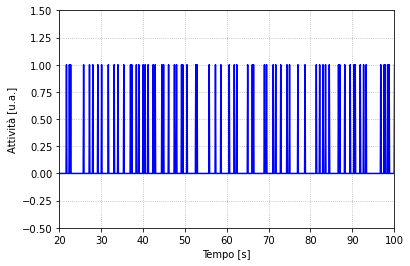

In [8]:
#plt.subplot(x,y,2)
plt.plot(time,output['activity_rtn'][15][0,:,1], color='b')
plt.xlabel('Tempo [s]')
plt.ylabel('Attività [u.a.]')
plt.xlim(20,100)
plt.ylim(-0.5,1.5)
plt.grid(linestyle='dotted')
plt.savefig('../Figure/attività_simulata.pdf')
plt.show()

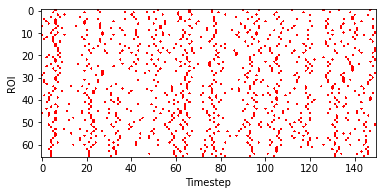

In [15]:
from matplotlib import colors

cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)


#plt.figure(figsize=(15,5))
plt.imshow(np.transpose(output['activity_rtn'][15][0,0:150,:]), cmap=cmap, norm=norm)
plt.xlabel('Timestep')
#plt.colorbar()

plt.ylabel('ROI')
plt.savefig('../Figure/attività_cascata.pdf',bbox_inches='tight')
plt.show()


In [11]:
time.shape[0]-len(convolved_signals[0,0,:])+1


250

In [12]:

#plt.subplot(x,y,3)
#plt.plot(time[0+len(hrf)-1:len(convolved_signals[0,0,:])+len(hrf)-1], convolved_signals[0,0,:], color='r')
#plt.plot(time,output['activity_rtn'][15][0,:,1], color='b')
#plt.xlim(0,50)
#plt.plot(time[0:filtered_signals.shape[2]],filtered_signals[0,0,:], label='filtered')
#plt.legend()
#plt.xlabel('time')
#plt.title('convoluted signal')
#plt.show()

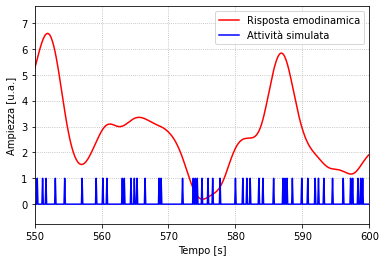

In [13]:
 
#plt.subplot(x,y,3)
plt.plot(time[len(hrf)-1:len(convolved_signals[0,0,:])+len(hrf)-1], convolved_signals[0,0,:], color='r', label='Risposta emodinamica')
plt.plot(time,output['activity_rtn'][15][0,:,1], color='b', label='Attività simulata')
plt.xlim(550,600)
plt.grid(linestyle='dotted')
#plt.plot(time[0:filtered_signals.shape[2]],filtered_signals[0,0,:], label='filtered')
plt.legend()
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza [u.a.]')
plt.savefig('../Figure/convoluzione_attività.pdf')
#plt.title('convoluted signal')
plt.show()

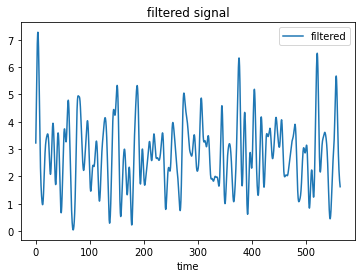

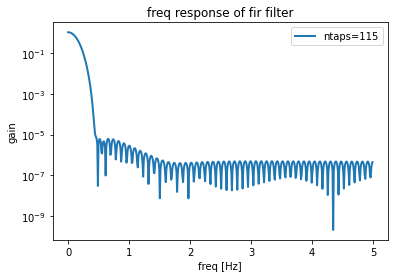

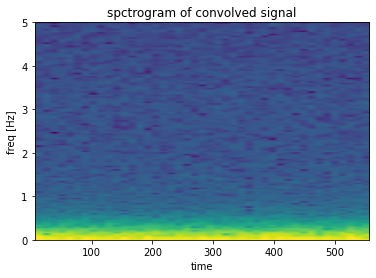

In [14]:
#plt.subplot(x,y,4)
plt.plot(time[0:filtered_signals.shape[2]],filtered_signals[0,0,:], label='filtered')
plt.xlabel('time')
plt.legend()
plt.title('filtered signal')
plt.show()


#plt.subplot(x,y,5)
w,h=signal.freqz(filt_fir)
plt.plot((w/np.pi)*nyquist_freq, np.absolute(h), linewidth=2, label='ntaps=%i'%len(filt_fir))
plt.legend()
plt.xlabel('freq [Hz]')
plt.ylabel('gain')
plt.title('freq response of fir filter')
plt.semilogy()
plt.show()

#plt.subplot(x,y,6)
plt.specgram(convolved_signals[0,0,:],Fs=10)
plt.title('spctrogram of convolved signal')
plt.xlabel('time')
plt.ylabel('freq [Hz]')
plt.show()


#plt.tight_layout()
#plt.show()